# Homework 3
## Student: Davide Gariglio (s292964)
***

### Import libraries

In [2]:
import numpy as np 
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import math

### General functions for the homework

We are required to run the epidemic for different graphs.
In order to have a compact and organized code during the problem execution, I defined general methods in this section of the notebook

##### Functions related to the graph creation

In [81]:
# it takes as input the number of nodes n and the number of closest nodes k to create the link
def generator_k_regular_graph(n, k):
    # check
    if (k > n) or (n <= 0) or (k <= 1):
        raise ValueError("Invalid parameters")

    nodes = list(range(n))
    edges = []

    # if k is not even, we make it in order to have an integer result for k/2
    if k % 2 != 0:
        k = k-1
    
    # retrieve the index offset of the nearest neighbors
    relative_neighbors = np.concatenate([np.arange(-k/2, 0), np.arange(1, k/2+1)])

    # for every node
    for node in nodes:
        # we thake the the index offset of the neighbors
        for neighbor in relative_neighbors:
            # Add an edge between each node and the k nodes whose index is closest to the node's own index
            edges.append((node, nodes[(node + int(neighbor)) % n]))

    graph = nx.Graph()
    graph.add_nodes_from(nodes)  # Needed to keep nodes in ascending order
    graph.add_edges_from(edges)
#     nx.draw_circular(graph)

    return graph

In [82]:
# Generate a random graph according to the preferential attachment model.
def generator_preferential_attachment(nodes, k_degree):
    
    if (k_degree > nodes) or (nodes <= 0) or (k_degree <= 1):
        raise ValueError("Invalid parameters")

    graph = nx.complete_graph(k_degree+1, nx.DiGraph())
    
    degree_sequence = sorted([d for n, d in graph.out_degree()], reverse=True)
    
    # round k parameter
    cf = math.floor(k_degree/2)
    cc = math.ceil(k_degree/2)
    
    for node in range(k_degree+1, nodes):
    
        in_deg = np.array([d for n, d in graph.in_degree()])
        in_deg_p = in_deg/sum(in_deg)
    
        if node%2 == 0:
            connect_nodes = np.random.choice(range(len(in_deg)),p=in_deg_p, size=cf, replace=False) 
        else:
            connect_nodes = np.random.choice(range(len(in_deg)),p=in_deg_p, size=cc, replace=False) 
        
        for cn in connect_nodes:
            graph.add_edge(cn, node)
            graph.add_edge(node, cn) 
            
    return graph


##### Functions related to the epidemic evolution

In [83]:
# SIR simulatio definition.
# takes as input the graph, the parameters related to the infection 
def simulation_SIR(graph, N_nodes, beta, rho, n_weeks, n_infected_init, vacc = None):

    agents = np.zeros(N_nodes, dtype="int")
    appo_agents = np.zeros(N_nodes, dtype="int")

    # define the initial infected agents
    seed = [np.random.choice(N_nodes-1, size = n_infected_init)]
    for s in seed:
        agents[s] = 1

    # define states vectors
    susceptibles = np.zeros(n_weeks, dtype="int")
    infected = np.zeros(n_weeks, dtype="int")
    recovered = np.zeros(n_weeks, dtype="int")
    new_infected = np.zeros(n_weeks, dtype="int")
    vaccinated = np.zeros(n_weeks, dtype="int")
    new_vaccinated = np.zeros(n_weeks, dtype="int")

    # define initial conditions
    susceptibles[0] = N_nodes - n_infected_init
    infected[0] = n_infected_init
    new_infected[0] = n_infected_init
    susceptibles[0] = len(np.where(agents[:] == 0)[0])
    infected[0] = len(np.where(agents[:] == 1)[0])
    recovered[0] = len(np.where(agents[:] == 2)[0])
    already_vaccinated_agents = 0

    # for every week
    for j in range(1, n_weeks):
        week_infected = 0

        # if SIRV model, we vaccinate some agents at the beginning of the week
        if vacc is not None:
            already_vaccinated_agents = vaccinated[j-1] 
            not_vaccinated_agents = N_nodes - vaccinated[j-1] 
            nodes_vacc = int(N_nodes/100*vacc[j-1]) # node vaccinated at step at week j
            
            if nodes_vacc > already_vaccinated_agents:
                candidates = np.where(agents[:] != 3)[0]
                vaccinated_agents = np.random.choice(candidates, 
                                                     size=nodes_vacc - already_vaccinated_agents)
                
                for node in vaccinated_agents:
                    agents[node] = 3 # state Vaccinated
                    new_vaccinated[j] +=1
                    
        appo_agents = np.array(agents)
        for i, agent in enumerate(agents):

            if agent == 0: # state Susceptible
                neighbors = list(graph.neighbors(i))
                m = 0
                for z in neighbors:
                    if agents[z] == 1:
                        m += 1
                if m!=0:
                    pStoI = 1-(1-beta)**m # probability to get infected
                    res = np.random.choice(2, p=[pStoI, 1-pStoI])
                    if res == 0:
                        appo_agents[i] = 1 # infection occurred
                        week_infected += 1

            if agent == 1: # state Infected
                pItoR = rho # probability to recovered
                res = np.random.choice(2, p=[pItoR, 1 - pItoR])
                if res == 0:
                    appo_agents[i] = 2 # recovery occurred

            #if agent == 2: # state Recovered: nothing happens

        for i, agent in enumerate(appo_agents):
            if agent != agents[i]:
                agents[i] = agent
                
        #update situation
        susceptibles[j] = len(np.where(agents[:] == 0)[0])
        infected[j] = len(np.where(agents[:] == 1)[0])
        recovered[j] = len(np.where(agents[:] == 2)[0])
        vaccinated[j] = already_vaccinated_agents + new_vaccinated[j]
        new_infected[j] = week_infected

    if vacc is not None:
        return susceptibles, infected, recovered, new_infected, vaccinated, new_vaccinated
    else:
        return susceptibles, infected, recovered, new_infected

##### epidemic definition and internaly run the evolution

In [84]:
# epidemic simulation
def epidemic(n_simulations, 
             type_graph, 
             k_neighbors,
             n_nodes, 
             beta, 
             rho, 
             n_weeks, 
             n_infected_init, 
             vacc = None,
             prob = 0.5,):
    
    # create the graph  
    if type_graph == "k_regular":
        graph = generator_k_regular_graph(n_nodes, k_neighbors)
    elif type_graph == "preferential_attachment":
        graph = generator_preferential_attachment(n_nodes, k_neighbors)
    else:
        print("Invalid name")
        return None
    
    # Initialize arrays for computing averages over simulations
    S = np.zeros((n_simulations, n_weeks+1), dtype="int")
    I = np.zeros((n_simulations, n_weeks+1), dtype="int")
    R = np.zeros((n_simulations, n_weeks+1), dtype="int")
    NI = np.zeros((n_simulations, n_weeks+1), dtype="int")
    if vacc is not None:
        V = np.zeros((n_simulations, n_weeks+1), dtype="int")
        NV = np.zeros((n_simulations, n_weeks+1), dtype="int")
    
    for j in range(n_simulations):
        
        # SIRV model
        if vacc is not None:
            s, i, r, ni, v, nv  = simulation_SIR(graph = graph,
                                                 N_nodes = n_nodes, 
                                                 beta = beta, 
                                                 rho = rho, 
                                                 n_weeks = n_weeks+1, 
                                                 n_infected_init = n_infected_init,
                                                 vacc = vacc)
            S[j, :] = s
            I[j, :] = i
            R[j, :] = r
            NI[j,:] = ni
            V[j, :] = v
            NV[j,:] = nv
            
        # SIR model
        else:
            s, i, r, ni = simulation_SIR(graph = graph,
                                         N_nodes = n_nodes,
                                         beta = beta, 
                                         rho = rho, 
                                         n_weeks = n_weeks+1,  
                                         n_infected_init = n_infected_init)
            
            S[j, :] = s
            I[j, :] = i
            R[j, :] = r
            NI[j,:] = ni
    
    # average result through all simulation
    avg_S = np.average(S, axis=0)
    avg_I = np.average(I, axis=0)
    avg_R = np.average(R, axis=0)
    avg_NI = np.average(NI, axis=0)
    if vacc is not None:
        avg_V = np.average(V, axis=0)
        avg_NV = np.average(NV, axis=0)
    
    if vacc is not None:
        return avg_S, avg_I, avg_R, avg_NI, avg_V, avg_NV
    else:
        return avg_S, avg_I, avg_R, avg_NI

##### Functions for plot

In [85]:
# SIR (SIRV) model plot
def sir_plot(s, i, r, v=[], file=None):
    fig, ax = plt.subplots(figsize=(10, 6))

    ticks = np.arange(0, s.shape[0], dtype=int)

    ax.plot(ticks, s, label="S", color="blue", marker=".")
    ax.plot(ticks, i, label="I", color="red", marker=".")
    ax.plot(ticks, r, label="R", color="green", marker=".")
    if len(v) > 0:
        ax.plot(ticks, v, label="V", color="turquoise", marker=".")

    ax.set_xticks(ticks)
    ax.set_xlabel('Week')
    ax.set_ylabel('Number of nodes (people)')
    ax.grid(alpha=0.3)
    ax.legend()

    if file:
        plt.savefig(file)
    else:
        plt.show()

# new infection model plot
def ni_plot(ni, file=None):
    fig, ax = plt.subplots(figsize=(10, 6))

    ticks = np.arange(0, ni.shape[0], dtype=int)

    ax.plot(ticks, ni, color="red", marker=".")

    ax.set_xticks(ticks)
    ax.set_xlabel('Week')
    ax.set_ylabel('Number of newly infected nodes')
    ax.grid(alpha=0.3)

    if file:
        plt.savefig(file)
    else:
        plt.show()
        
# new infection-vaccination model plot
def ninv_plot(ni, nv, file=None):
    fig, ax = plt.subplots(figsize=(10, 6))

    ticks = np.arange(0, ni.shape[0], dtype=int)

    ax.plot(ticks, ni, color="red", label="newly I", marker=".")
    ax.plot(ticks, nv, color="turquoise", label="newly V", marker=".")

    ax.set_xticks(ticks)
    ax.set_xlabel('Week')
    ax.set_ylabel('Number of nodes')
    ax.grid(alpha=0.3)
    ax.legend()

    if file:
        plt.savefig(file)
    else:
        plt.show()

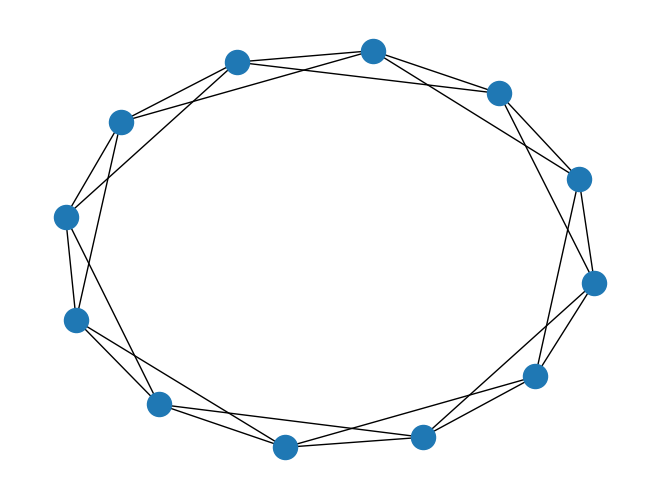

In [87]:
regular_g_example=generator_k_regular_graph(12, 4)
nx.draw(regular_g_example)
plt.savefig('imgs/k_regular_example.png')

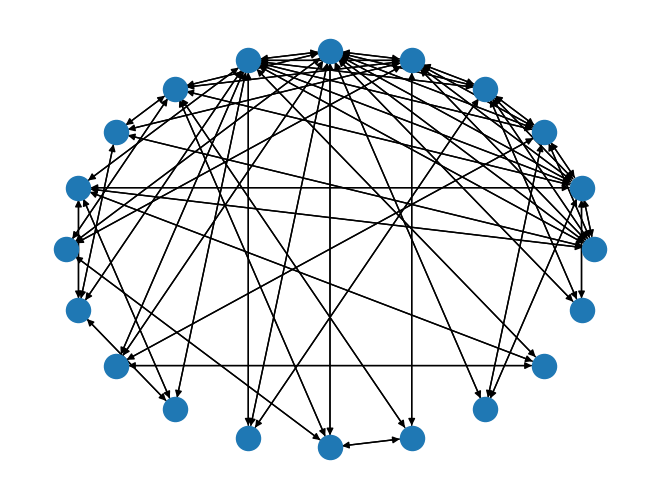

In [100]:
random_preferential_example=generator_preferential_attachment(20, 6)
pos = nx.circular_layout(random_preferential_example)
nx.draw(random_preferential_example, pos)
plt.savefig('imgs/random_example.png')

# Problem 1

## 1.1 - Preliminary steps

### Epidemic on a known graph

In the first problem an epidemic is simulated on a symmetric $k$-regular undirected graph $\mathcal{G}$ with $|\mathcal{V}|=500$ nodes and $k=4$ for $15$ weeks (steps). 
The graph is unweighted and undirected; our network system simulates pairwise interactions and spontaneous mutations.
Each individual associated with a state $i$ related to the H1N1-virus infection. 
Consider the state space $\mathcal{A}=\{0, 1, 2\}$ is corresponding respectively to:
* **S** (susceptible)
* **I** (infected)
* **R** (recovered)


In [27]:
# as requested we use 500 nodes, k=4, beta = 0.3, rho = 0.7 and 10 infected nodes at the beginning for 15 weeks
# 100 simulations

# parameters definition
n_simulations=100
k_neighbors= 4
n_nodes=500
beta=0.3
rho=0.7
n_weeks=15
n_infected_init=10

#run the epidemic simulations
s, i, r, ni = epidemic(n_simulations=n_simulations,
                       type_graph = 'k_regular',
                       k_neighbors= k_neighbors,
                       n_nodes=n_nodes,
                       beta=beta,
                       rho=rho,
                       n_weeks=n_weeks,
                       n_infected_init=n_infected_init)

Plot of the avg SIR model over the 100 simulations

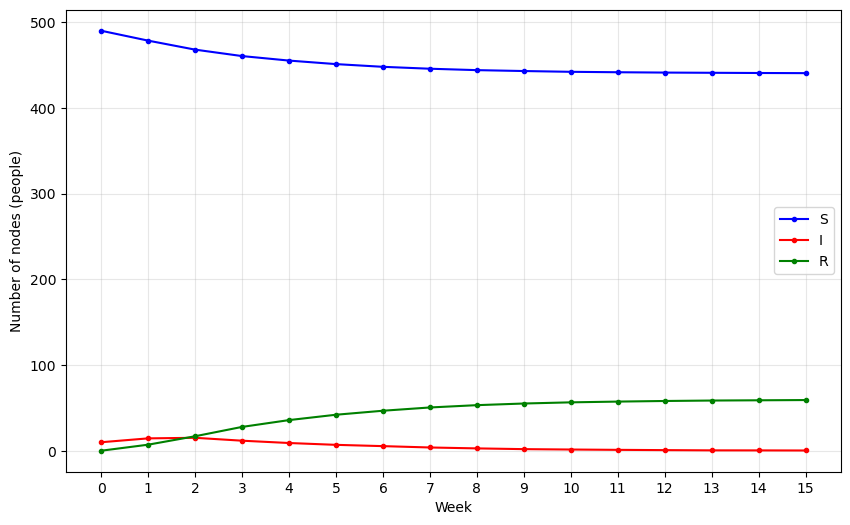

In [28]:
sir_plot(s, i, r, file="imgs/SIR_knownGraph.png")

Plot the average new infected (NI) agents over the different 15 weeks simulations 

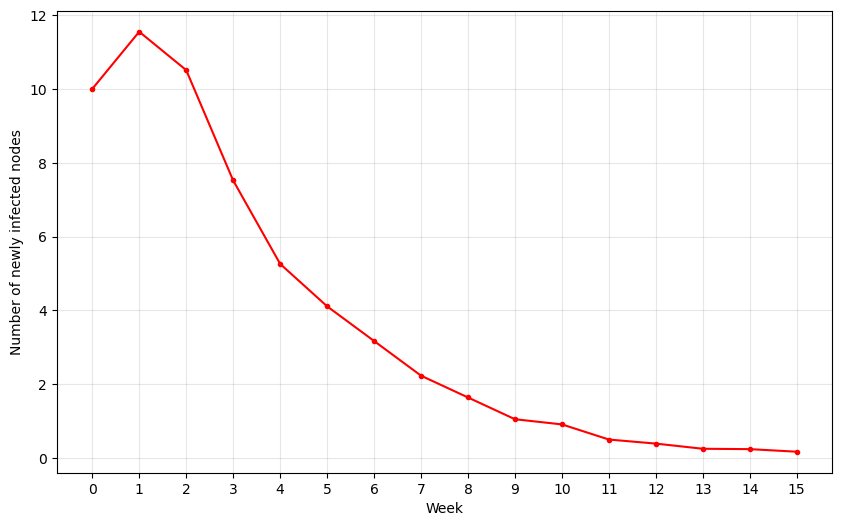

In [29]:
ni_plot(ni, file="imgs/NI_knownGraph.png")

For the first two weeks the randomly initialized nodes propagate the infection, however the epidemic slows early because is not able to reach the other nodes fast enough; this is due to the graph structure.
Moreover, if we increase beta the epidemics will have more infected people.

### Generate a random graph with rpeferential attachment method

In [34]:
# we are required to use n_nodes > 900
# general k can be changed afterwards
nodes = 1000
k_degree = 6
graph = generator_preferential_attachment(nodes, k_degree)
W = nx.adjacency_matrix(graph)
W = W.toarray()
w = np.sum(W, axis=1)
print("Average degree: ", np.mean(w))

Average degree:  6.0


C:\Users\garig\AppData\Local\Temp\ipykernel_8836\863960521.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  W = nx.adjacency_matrix(graph)


## 1.2 - Simulate pandemic without vaccination

Discrete dime simulation of SIR model using preferential attachment random graph generated before.
New links are created according to the probabilities described in the assignment and in the attached report.
In this simulation we use:
k = 6,
n_nodes = 500,
beta = 0.3,
rho = 0.7 ,
node_infected_init = 10,

In [35]:
s, i, r, ni = epidemic(n_simulations=100,
                       type_graph="preferential_attachment",
                       k_neighbors= 6,
                       n_nodes=500,
                       beta=0.3,
                       rho=0.7,
                       n_weeks=15,
                       n_infected_init=10)

Plot of the avg SIR model over the 100 simulations

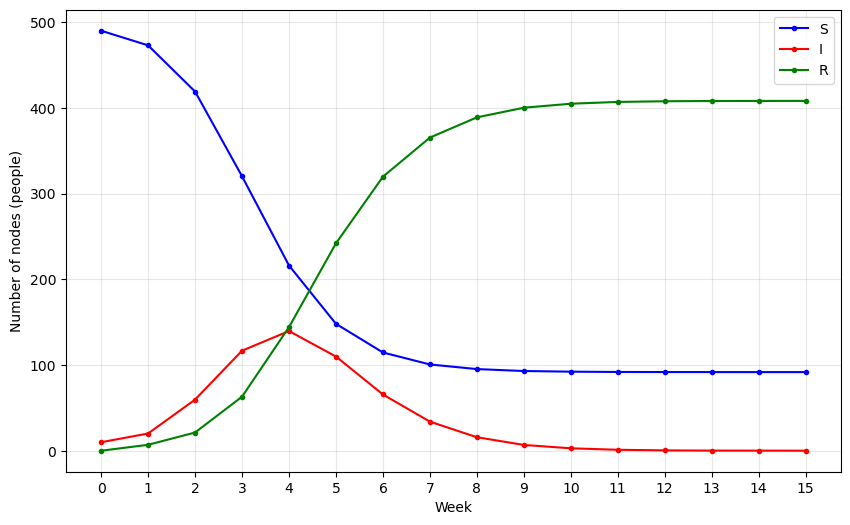

In [37]:
sir_plot(s, i, r, file="imgs/withoutvacc.png")

Plot the average new infected (NI) agents over the different 15 weeks simulations 

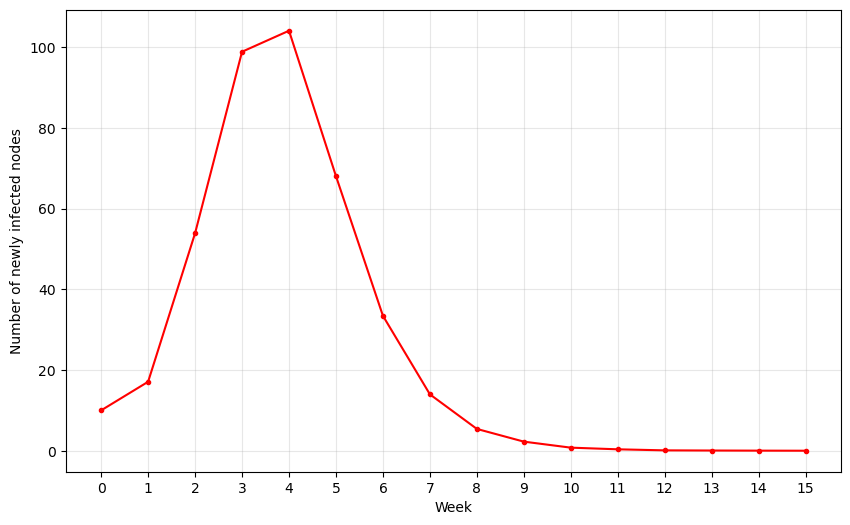

In [39]:
ni_plot(ni, file="imgs/withoutvaccNI.png")

We can that infection cases and newly infected agents present a bell shape.
The infection propagates fast, with a peak in the 4th week with more than 100 new cases.
In the same time, a lot of people recovered (due to rho = 0.7) and consequently the susceptible increased.
The epidemic does not stop early as in the previous problem due to the graph construction, but has been contained after 6 weeks more or less.

## 1.3 - Simulate a pandemic with vaccination

We have to perform other simulations on the SIR model, but with vaccines.
Now the agent states are 4.
We are given the number of vaccines per time unit (week) and it is:
$$\text{Vacc}(t) = [5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60, 60]$$
note that this is a cumulative percentage number of the total population (agents/number of nodes) as stated in the assignment.
We assume that the vaccines works immediately.
We run the simulation with the same parameters as before (also with random graph based on preferential attachment)

In [40]:
vaccination_vector = [5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60, 60]

n_simulations=100
k_neighbors= 6
n_nodes=500
beta=0.3
rho=0.7
n_weeks=15
n_infected_init=10

s, i, r, ni, v, nv = epidemic(n_simulations=n_simulations,
                              type_graph="preferential_attachment",
                              k_neighbors= k_neighbors,
                              n_nodes=n_nodes,
                              beta=beta,
                              rho=rho,
                              n_weeks=n_weeks,
                              n_infected_init=n_infected_init,
                              vacc=vaccination_vector)

Plot of the avg SIR with vaccination model over the 100 simulations

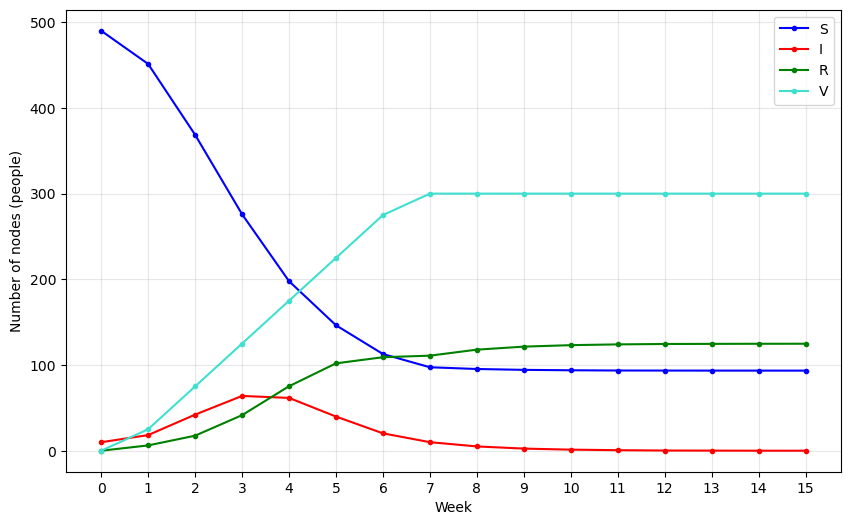

In [42]:
sir_plot(s, i, r, v, file="imgs/withvacc.png")

Plot the average new infected (NI) and new vaccinated (NV) agents over the different 15 weeks simulations 

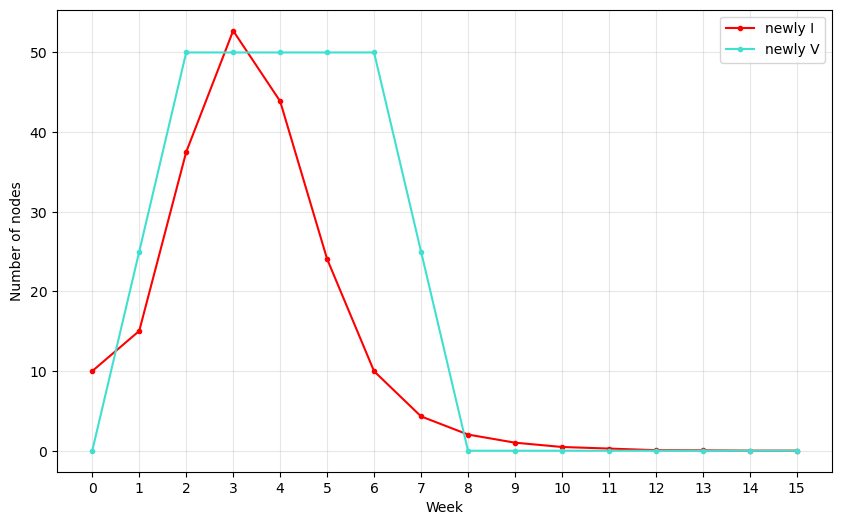

In [43]:
ninv_plot(ni, nv, file="imgs/withvaccNI.png")

The vaccines were very useful and the epidemic stops drastically.
recovered people are less than the model before because the vaccines avoided the infection.

## 1.4 - The H1N1 pandemic in Sweden 2009

Estimate $k$, $\beta$ and $\rho$ for our model which best match the  real case H1N1 pandemic in Sweden in 2009.
We have the fraction of population that had received vaccination during these weeks in the simulation.
$$\text{Vacc}(t)=[5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]$$

We take a scaled portion of the Sweden population with n_nodes = 934.
The scaled amount of new infected is 
$$I_0(t)=[1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]$$

In order to estimate the parameters we use the algorithm described in the homework assignment and is defined as follows


In [46]:
def search_parameters(vaccination_vector, infection_vector, 
                      type_graph, k0 = 10, dk = 1, beta0 = 0.3, 
                      dbeta = 0.1, rho0 = 0.6, drho = 0.1, p0 = 0.5, dp = 0.05):

    
    n_infected_init = 1
    n_simulations = 10
    n_weeks = 15
    N_nodes = 934
    
    step = 0
    
    old_RMSE = 100
    best_RMSE = 100
    best_k = 0
    best_beta = 0
    best_rho = 0
    best_prob = 0
    
    alpha = 1

    while True:
        print("\nStarting step {} ...".format(step))
        
        # k interval creation
        k_UB = k0+dk*alpha
        k_LB = k0-dk*alpha
        if k_LB < 2:
            k_LB = 2
        k = np.array([k_LB, k0, k_UB])
        
        
        # beta interval creation
        beta_LB = beta0-dbeta*alpha
        if beta_LB < 0:
            beta_LB = 0

        beta_UB = beta0+dbeta*alpha
        if beta_UB > 1:
            beta_UB = 1
        beta = np.array([beta_LB, beta0, beta_UB])
        
        # rho interval creation 
        rho_LB = rho0-drho*alpha
        if rho_LB < 0:
            rho_LB = 0
        
        rho_UB = rho0+drho*alpha
        if rho_UB > 1:
            rho_UB = 1
        rho = np.array([rho_LB, rho0, rho_UB])
        
        # parameters meshgrid creation
        parameters_set = np.array(np.meshgrid(k, beta, rho)).T.reshape(-1,3)
        RMSE = np.zeros(len(parameters_set))
        array_avg_new_I = np.zeros((len(parameters_set), n_weeks))

        for i, p in enumerate(parameters_set):

            k = int(p[0])
            beta = p[1]
            rho = p[2]
            
            # graph creation
            if type_graph == "preferential_attachment":
                graph = generator_preferential_attachment(N_nodes, k)
                
            # simulate parameter
            new_I = np.zeros((n_simulations, n_weeks))
            for j in range(n_simulations):
                _, _, _, new_infected, _, _  = simulation_SIR(graph, N_nodes, beta, rho, n_weeks, n_infected_init, vaccination_vector)
                new_I[j,:] = new_infected
                
            avg_new_Infected = np.average(new_I, axis=0)
            array_avg_new_I[i] = avg_new_Infected
            RMSE[i] = np.sqrt(1/len(avg_new_Infected)* np.sum((avg_new_Infected - infection_vector)**2))

        index_best_RMSE = np.random.choice(np.where(RMSE == np.amin(RMSE))[0], size=1)[0]
        new_k = parameters_set[index_best_RMSE][0]
        new_beta = parameters_set[index_best_RMSE][1]
        new_rho = parameters_set[index_best_RMSE][2]
        
        print("Best RMSE {:.3f}".format(RMSE[index_best_RMSE]))

        print("Previous parameter: k={:.3f} beta={:.3f} rho={:.3f}".format(k0, beta0, rho0))
        print("Actual parameters : k={:.3f} beta={:.3f} rho={:.3f}".format(new_k, new_beta, new_rho))
        
        #save best result
        if RMSE[index_best_RMSE] <= best_RMSE:
            print("New Best result found ..........................")
            best_RMSE = RMSE[index_best_RMSE]
            best_k = new_k
            best_beta = new_beta
            best_rho = new_rho
            alpha = 1 # explore new interval and surrounding value
            
        # explored all possible combination in that interval, try new one
        if new_k == k0 and new_beta == beta0 and new_rho == rho0:
            alpha += 1
            step += 1
            
        else:
            # moving the center of interval of exploration and explore new interval
            k0 = new_k
            beta0 = new_beta
            rho0 = new_rho
            old_RMSE = RMSE[index_best_RMSE]
            step += 1
            
        if alpha >= 6 or step >= 100:
            break
        
    print("Algorithm finished with {} steps".format(step))
    
    return best_RMSE, best_k, best_beta, best_rho

In [47]:
vaccination_vector = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]
infection_vector  =  [1, 1, 3,  5,  9,  17, 32, 32, 17, 5,  2,  1,  0,  0,  0 ]
RMSE, new_k, new_beta, new_rho = search_parameters(vaccination_vector, infection_vector, 
                                                   type_graph = "preferential_attachment", 
                                                   k0 = 8, dk = 1, 
                                                   beta0 = 0.2, dbeta = 0.025, 
                                                   rho0 = 0.6, drho = 0.025)


Starting step 0 ...
Best RMSE 5.256
Previous parameter: k=8.000 beta=0.200 rho=0.600
Actual parameters : k=8.000 beta=0.200 rho=0.575
New Best result found ..........................

Starting step 1 ...
Best RMSE 4.571
Previous parameter: k=8.000 beta=0.200 rho=0.575
Actual parameters : k=8.000 beta=0.225 rho=0.600
New Best result found ..........................

Starting step 2 ...
Best RMSE 4.851
Previous parameter: k=8.000 beta=0.225 rho=0.600
Actual parameters : k=7.000 beta=0.200 rho=0.575

Starting step 3 ...
Best RMSE 3.885
Previous parameter: k=7.000 beta=0.200 rho=0.575
Actual parameters : k=6.000 beta=0.225 rho=0.575
New Best result found ..........................

Starting step 4 ...
Best RMSE 4.205
Previous parameter: k=6.000 beta=0.225 rho=0.575
Actual parameters : k=6.000 beta=0.225 rho=0.575

Starting step 5 ...
Best RMSE 4.636
Previous parameter: k=6.000 beta=0.225 rho=0.575
Actual parameters : k=8.000 beta=0.175 rho=0.625

Starting step 6 ...
Best RMSE 2.456
Previo

After we find the best parameters we simulate the epidemic

In [48]:
print("Best result achieve: RMSE:{:.2f}, k:{:.2f}, Beta:{:.2f}, rho:{:.2f}".format( RMSE, new_k, new_beta, new_rho))


Best result achieve: RMSE:2.46, k:10.00, Beta:0.17, rho:0.62


In [53]:
vaccination_vector = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
#print best parameters found
n_simulations = 100
n_nodes = 934
n_weeks = 15
s, i, r, ni, v, nv = epidemic(n_simulations=n_simulations,
                              type_graph="preferential_attachment",
                              k_neighbors=int(new_k),
                              n_nodes=n_nodes,
                              beta = new_beta,
                              rho = new_rho,
                              n_weeks=n_weeks,
                              n_infected_init=1,
                              vacc=vaccination_vector)
#best RMSE:2.64, k:10.00, Beta:0.17, rho:0.62

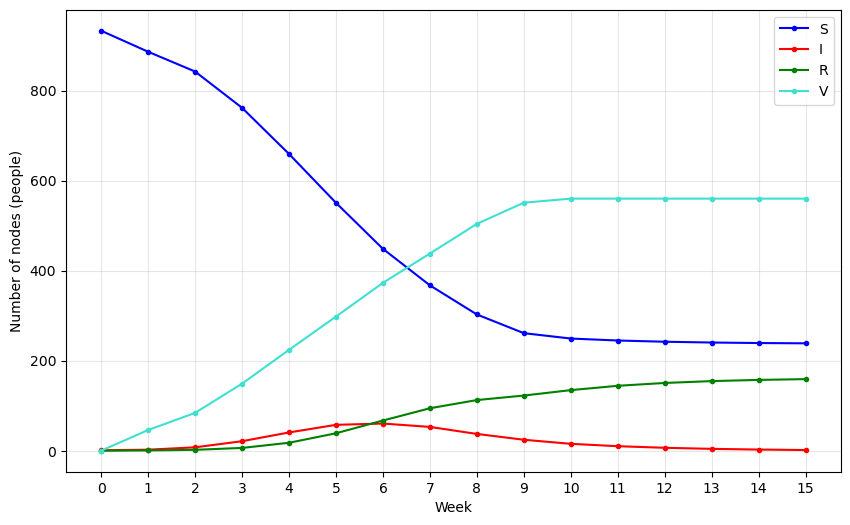

In [50]:
sir_plot(s, i, r, v, file="imgs/sim_best_param.png")

Now we compare actual infected with the one obtained from the simulation

In [54]:
# plot comparison between new infection simulated and predicted
def ni_comparison_plot(ni, ni_target, file=None):
    fig, ax = plt.subplots(figsize=(10, 6))

    ticks = np.arange(0, ni.shape[0], dtype=int)

    ax.plot(ticks, ni, color="red", label="newly I (simulation)", marker=".")
    ax.plot(ticks, ni_target, color="black", label="newly I (real)", linestyle="--")

    ax.set_xticks(ticks)
    ax.set_xlabel('Week')
    ax.set_ylabel('Number of nodes')
    ax.grid(alpha=0.3)
    ax.legend()

    if file:
        plt.savefig(file)
    else:
        plt.show()

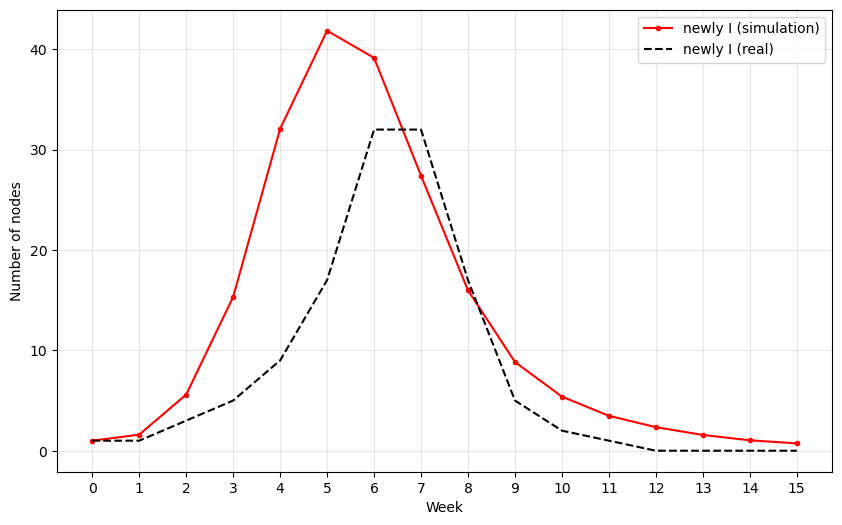

In [55]:
infection_vector = [1, 1,  3,  5,  9,  17, 32, 32, 17, 5,  2,  1,  0,  0,  0,  0]
ni_comparison_plot(ni, infection_vector, file="imgs/NI_comparison.png")

# Problem 2

## Coloring a

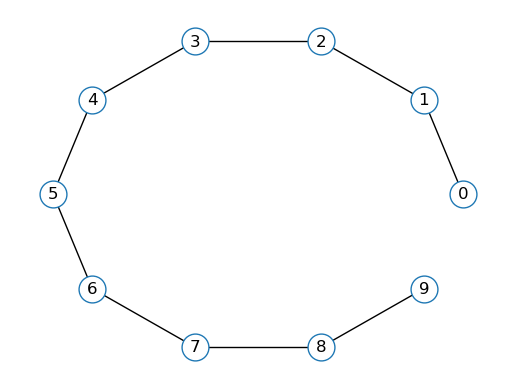

In [3]:
B=nx.Graph()
B.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
B.add_edge(0,1)
B.add_edge(1,2)
B.add_edge(2,3)
B.add_edge(3,4)
B.add_edge(4,5)
B.add_edge(5,6)
B.add_edge(6,7)
B.add_edge(7,8)
B.add_edge(8,9)


#plot
pos = nx.circular_layout(B)
nx.draw_networkx_nodes(B, pos, linewidths=3)
nx.draw(B, pos, node_color="#ffffff", with_labels=True)

plt.savefig("imgs/graph_coloring_1")

In [30]:
num_iterations=500
# 2 possible colors
colors = {0: "red", 1: "green"}
values= [0,1]
# 0: red. all nodes are initialized as red
begin_value= [0]*len(B.nodes)


In [31]:
from tqdm import tqdm
from copy import deepcopy 

potential_fs = []
val_t=0
#at the beginning are all nodes at 0
for node, value in zip(B.nodes(), begin_value):
    B.nodes[node]["value"] = value

# at the beginning, best_value --> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
best_value=[]
for node in B.nodes():
  best_value.append(B.nodes[node]["value"]) 


# initialization of utility
best_utility = np.inf

value_iter_25=[]
value_begin=[]
for node in B.nodes():
  value_begin.append(B.nodes[node]["value"]) 
value_iter_25.append(value_begin)



# start of the simulation
for val_t in tqdm(range(1, num_iterations+1)):
    # choose a node randomly
    node_x = np.random.choice(B.nodes())
    # select nodes close to the one considered
    nodes_close = list(B.neighbors(node_x))

    # consider the actual value
    actual_value=[]
    for node in B.nodes():
      actual_value.append(B.nodes[node]["value"]) 
    actual_array=np.array(actual_value)

    # select nodes close to the one considered
    nodes_close = list(B.neighbors(node_x))

    # cost computation
    lista_cost=[]
    for v in values:
      lista_cost.append(np.sum(actual_array[nodes_close] == v))
    cost_array=np.array(lista_cost)

    # compute the probabilities for each new possible state
    prob = np.exp(-(val_t/100)*cost_array)
    p = np.array(prob) / np.sum(prob)

    # compute the new value
    new_value = np.random.choice(values, p=p)

    # get the new value
    B.nodes[node_x]["value"] = new_value
    actual_array[node_x] = new_value

    # divide the simulation for every 25 iterations
    if (val_t + 1) % 25 == 0:
        value_iter_25.append(deepcopy(actual_array))


    # utility steps
    tot = 0
    last = 0
    for i in range(len(B.nodes)):
        nodes_close = list(B.neighbors(i))
        lista=[]
        for value in values:
            lista.append(np.sum(actual_array[nodes_close] == value))
        lista_array=np.array(lista)
        tot = tot+ lista_array[actual_array[i]]
    last = tot*0.5
    potential_fs.append(last)

    # utility update
    if potential_fs[-1] < best_utility:
        # if it is better we update the best up tp now
        best_value = deepcopy(actual_array)
        best_utility = potential_fs[-1]


    # stop the process if the utility has reached the value 0
    if potential_fs[-1] == 0:
        value_iter_25.append(deepcopy(actual_array))
        tot = 0
        last=0
        for i in range(len(B.nodes)):
            nodes_close = list(B.neighbors(i))
            lista_cost=[]
            
            for value in values:
                lista_cost.append(np.sum(actual_array[nodes_close] == value))
                
            lista_array=np.array(lista_cost)
            tot = tot + lista_array[actual_array[i]]
        last = tot*0.5
        potential_fs.append(last)
        
        break

fin_it=val_t-1

 28%|██▊       | 139/500 [00:00<00:00, 2731.75it/s]


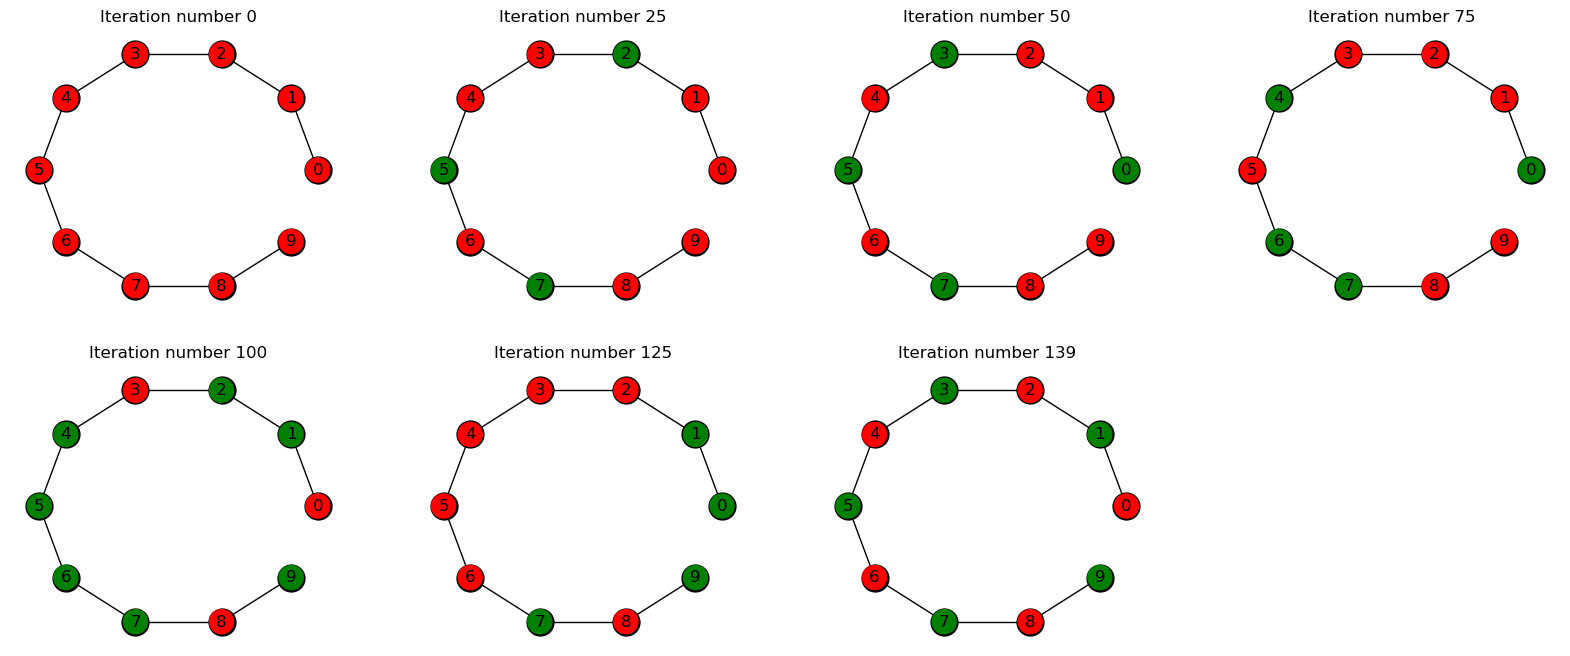

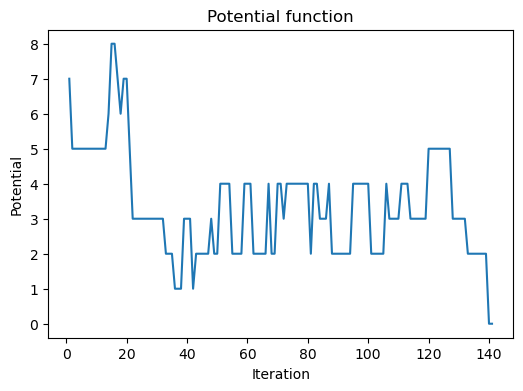

In [35]:
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for i in range(len(value_iter_25)-1):
    iteration = i * 25
    #print(iteration)
    j, k = int(i / 4), i % 4
    
    ax[j][k].set_title(f"Iteration number {iteration}")
    
    co = [colors[value_iter_25[i][n]] for n in B.nodes]
    nx.draw_networkx_nodes(B, pos, linewidths=3, edgecolors="#000000", ax=ax[j][k])
    nx.draw(B, pos, node_color=co, with_labels=True, ax=ax[j][k])

ax[1][-2].set_title(f"Iteration number {fin_it}")
co = [colors[value_iter_25[-1][n]] for n in B.nodes]
nx.draw_networkx_nodes(B, pos, linewidths=3, edgecolors="#000000", ax=ax[-1][-2])
nx.draw(B, pos, node_color=co, with_labels=True, ax=ax[-1][-2])

plt.savefig("imgs/ex_col_b_1.png")
i=0
j=0
k=0
fig.delaxes(ax[1,3])
plt.show()

fig, ax = plt.subplots(figsize=(6,4))

ax.set_title(f"Potential function")
ax.plot([i+1 for i in range(len(potential_fs))], potential_fs)
ax.set_xlabel("Iteration")
ax.set_ylabel("Potential")

plt.savefig("imgs/ex_col_b_potential.png")
i=0
j=0
k=0

The model is able to solve the graph coloring problem in 143 iterations

## Coloring b

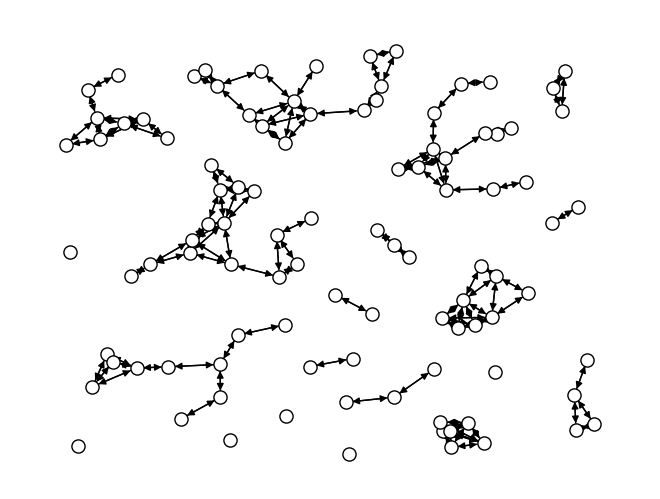

In [65]:
A = np.loadtxt("mats/wifi.mat")
coordinates = np.loadtxt("mats/coords.mat")

# build graph B
B = nx.DiGraph()
for j in range(A.shape[1]):
  for i in range(A.shape[0]):
    if np.any(A[i,j]==1):
      source = i
      destination= j
      B.add_edge(source, destination)   
    elif np.any(A[i,j]==0):
      B.add_node(i)


pos = {}
for n in B.nodes():
    pos[n] = coordinates[n, :]


nx.draw(B, pos, node_color="#ffffff", node_size=90, edgecolors="#000000")
plt.savefig("imgs/graph_col_2.png")

In [73]:
# set of colors
colors = {0: "red", 1: "green", 2: "blue", 3: "yellow", 4: "magenta", 5: "cyan", 6: "white", 7: "black"}
# we test with 1000, 2500 and 5000 iterations
num_iterations=2500
values=[]
for k in colors.keys():
  values.append(k)
init_value= [0]*len(B.nodes)

potential_fs = []
val_t=0
#at the beginning are all nodes at 0
for node, value in zip(B.nodes(), init_value):
    B.nodes[node]["value"] = value

# at the beginning, best_value --> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
best_value=[]
for node in B.nodes():
  best_value.append(B.nodes[node]["value"]) 

# initialization of utility
best_utility = np.inf

value_iter_25=[]
value_begin=[]
for node in B.nodes():
  value_begin.append(B.nodes[node]["value"]) 
value_iter_25.append(value_begin)


# start of the simulation
for val_t in tqdm(range(1, num_iterations+1)): 
    # choose a node randomly
    node_x = np.random.choice(B.nodes())
    # select nodes close to the one considered
    nodes_close = list(B.neighbors(node_x))

    # consider the actual value
    actual_value=[]
    for node in B.nodes():
      actual_value.append(B.nodes[node]["value"]) 
    actual_array=np.array(actual_value)

    # select nodes close to the one considered
    nodes_close = list(B.neighbors(node_x))

    #cost computation
    lista_cost=[]
    max_val=0
    sum_val=0
   
    for v in values:
      for x in actual_array[nodes_close]:
        
        max_val=max(2-abs(x-v), 0)
        sum_val=np.sum(max_val)
        lista_cost.append(sum_val) #actual_array[nodes_close] == value))
    cost_array=np.array(lista_cost)
      
    # compute the probabilities for each new possible state
    prob = np.exp(-(val_t/100)*cost_array)
    p = np.array(prob) / np.sum(prob)

    # compute the new value
    new_value = np.random.choice(values, p=p)

    # get the new value
    B.nodes[node_x]["value"] = new_value
    actual_array[node_x] = new_value

    # divide the simulation for every 25 iterations
    if (val_t + 1) % 25 == 0:
        value_iter_25.append(deepcopy(actual_array))
    
    # utility steps
    tot = 0
    last=0
    
    for i in range(len(B.nodes)):
        nodes_close = list(B.neighbors(i))
        lista=[]
        lista_cost=[] 
        max_val=0
        sum_val=0
     
        for v in values:
            for x in actual_array[nodes_close]:
                max_val=max(2-abs(x-v), 0)
                sum_val=np.sum(max_val)
                lista_cost.append(sum_val) #actual_array[nodes_close] == value))
        cost_array=np.array(lista_cost)
   
        tot = tot+ cost_array[actual_array[i]]
    last = tot*0.5
    potential_fs.append(last)

    # utility update
    if potential_fs[-1] < best_utility:
        best_value = deepcopy(actual_array)
        best_utility = potential_fs[-1]


    # stop the process if the utility has reached the value 0
    if potential_fs[-1] == 0:
        value_iter_25.append(deepcopy(actual_array))
        tot = 0
        last=0
        for i in range(len(B.nodes)):
            nodes_close = list(B.neighbors(i))
            lista=[]
            lista_cost=[]
            max_val=0
            sum_val=0
            
            for value in values:
                for x in actual_array[nodes_close]:
                    max_val=max(2-abs(x-value), 0)
                    sum_val=np.sum(max_val)
                lista_cost.append(sum_val) 
            cost_array=np.array(lista_cost)
            tot = tot+ cost_array[actual_array[i]]
        last = tot*0.5
        potential_fs.append(last)
        

        break
value_iter_25
fin_it=val_t-1


100%|██████████| 2500/2500 [00:47<00:00, 52.17it/s]


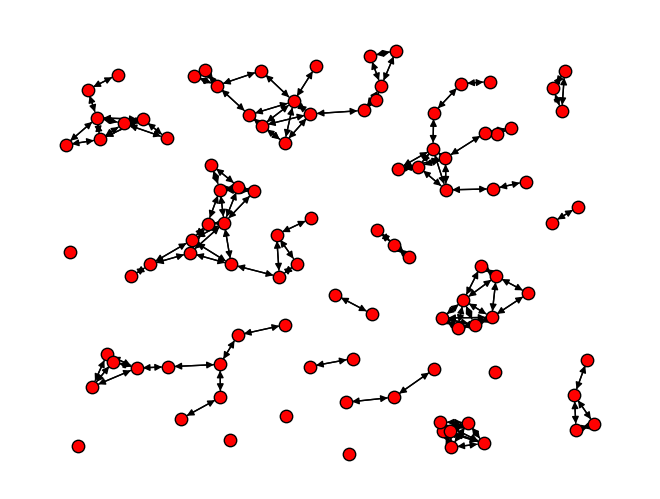

In [74]:
#Initial configuration of the graph B
nx.draw(B, pos, node_color="red", node_size=80, edgecolors="#000000") ###
plt.savefig("imgs/ex_col_b_initial_conf.png")

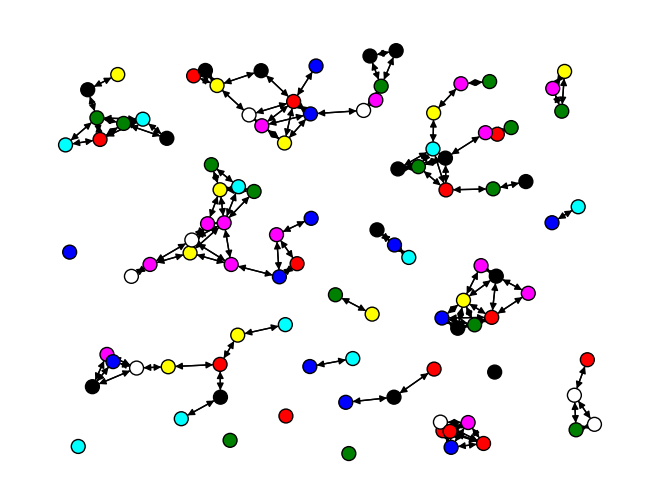

In [77]:
#Best final configuration of the graph B
best_col=[]
for n in B.nodes():
  best_col.append(colors[best_value[n]])
nx.draw(B, pos, node_color=best_col, node_size=100, edgecolors="#000000")
plt.savefig(f"imgs/ex_col_b_sol_{num_iterations}.png")

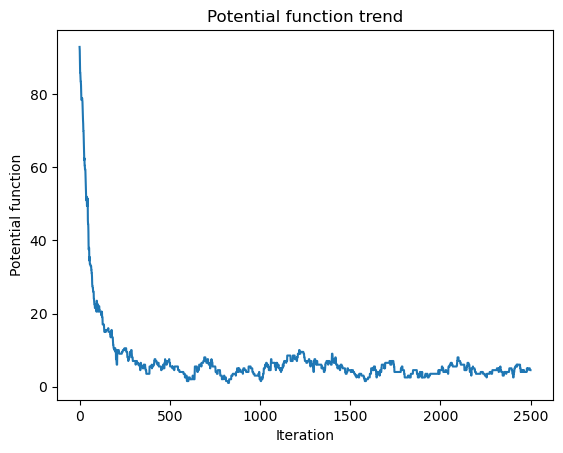

In [78]:
if fin_it == num_iterations:
    plt.plot(range(fin_it+2), potential_fs)
else:
    plt.plot(range(fin_it+1), potential_fs)

plt.xlabel("Iteration")
plt.ylabel("Potential function")
plt.title("Potential function trend")
plt.savefig(f"imgs/ex_col_b_potential_{num_iterations}.png")